In [1]:
import torch
import numpy as np

In [2]:
np.random.seed(1234)
torch.manual_seed(1234)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


# **NEURAL NETWORK**

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd

In [5]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, layer_size):
        super(PINN, self).__init__()
        self.lambda_1 = nn.Parameter(torch.Tensor([0]), requires_grad=True)
        self.lambda_2 = nn.Parameter(torch.Tensor([0]), requires_grad=True)
        self.lambda_3 = nn.Parameter(torch.Tensor([0]), requires_grad=True)

        self.fc1 = nn.Linear(input_dim, layer_size)
        self.fc2 = nn.Linear(layer_size, layer_size)
        self.fc3 = nn.Linear(layer_size, layer_size)
        self.fc4 = nn.Linear(layer_size, output_dim)

        

    def forward(self, input_0, input_1, dt, IRK_alpha, IRK_beta):
        u_0 = self.forward_iteration(input_0, dt, IRK_alpha.T, True)
        u_1 = self.forward_iteration(input_1, dt, (IRK_beta-IRK_alpha).T, False)
        return u_0, u_1



    def forward_iteration(self, x, dt, IRK_weights, flag_u0):
        x.requires_grad_(True)

        s = nn.Tanh()(self.fc1(x.float()))
        s = nn.Tanh()(self.fc2(s))
        s = nn.Tanh()(self.fc3(s))
        u = self.fc4(s)
        u_x = self.fwd_gradients(u, x)
        u_xx = self.fwd_gradients(u_x, x)
        u_xxx = self.fwd_gradients(u_xx, x)
        u_xxxx = self.fwd_gradients(u_xxx, x)

        f = - self.lambda_1*u*u_x - self.lambda_2*u_xx - self.lambda_3*u_xxxx
        
        if flag_u0:
            u_ = u - dt * torch.mm(f.double(), IRK_weights.double())
        else: #flag_u1
            u_ = u + dt * torch.mm(f.double(), IRK_weights.double())

        return u_



    def fwd_gradients(self, U, x):
        z = torch.ones(U.shape).to(device).requires_grad_(True)
        g = autograd.grad(U, x, grad_outputs=z, create_graph=True)[0]
        return autograd.grad(g, z, grad_outputs=torch.ones(g.shape).to(device), create_graph=True)[0]
    


    def predict(self, x):
        s = nn.Tanh()(self.fc1(x.float()))
        s = nn.Tanh()(self.fc2(s))
        s = nn.Tanh()(self.fc3(s))
        u = self.fc4(s)
        return u

# **OPTIMIZATION**

In [6]:
from torch.optim import LBFGS
from time import time
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm as tqdm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [7]:
class Train():
    def __init__(self, network, input_0, target_0, input_1, target_1, dt, q):
        self.net = network

        self.lbfgs_optim = LBFGS(self.net.parameters(), lr=1, max_iter=50000, line_search_fn='strong_wolfe')

        tmp = np.float32(np.loadtxt('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Code/Paper 2/Utilities/IRK_weights/Butcher_IRK%d.txt' % (q), ndmin = 2))
        weights = torch.from_numpy(np.reshape(tmp[0:q**2+q], (q+1, q)))
        self.IRK_alpha = weights[0:-1, :].to(device)
        self.IRK_beta = weights[-1:, :].to(device)
        self.IRK_times = torch.from_numpy(tmp[q**2+q:]).to(device)

        #### UNCOMMENT TO GET REPRODUCE RESULTS IN PAPER ############
        self.train_input_0, \
        self.validate_input_0, \
        self.train_target_0, \
        self.validate_target_0 = train_test_split(input_0.to(device), target_0.to(device), test_size=0.1, shuffle=True) #should it be shuffled???

        self.train_input_1, \
        self.validate_input_1, \
        self.train_target_1, \
        self.validate_target_1 = train_test_split(input_1.to(device), target_1.to(device), test_size=0.1, shuffle=True)
        #############################################################

        ### UNCOMMENT TO TRAIN WITHOUT SPLITTING TRAINING SET #######
        """
        self.train_input_0, self.train_target_0 = input_0.to(device), target_0.to(device)
        self.train_input_1, self.train_target_1 = input_1.to(device), target_1.to(device)
        """
        #############################################################


        self.dt = torch.tensor(dt).to(device)
        self.i = 0
        



    def train(self):
        start_time = time()
        self.train_iteration(self.train_input_0, self.train_target_0, self.train_input_1, self.train_target_1)

        end_time = time()


    def train_iteration(self, input_0, target_0, input_1, target_1):
        
        def closure():
            if torch.is_grad_enabled():
                self.lbfgs_optim.zero_grad()
            predict_0, predict_1 = self.net(input_0, input_1, self.dt, self.IRK_alpha, self.IRK_beta)
            loss = self.loss_function(predict_0, target_0, predict_1, target_1)
            if loss.requires_grad:
                loss.backward()

            if self.i % 100 == 0:
                
                print('Loss:', loss.item())

                self.plot_progress(idx_t0, x_data, u_data, input_0, predict_0)
                self.plot_progress(idx_t1, x_data, u_data, input_1, predict_1)
                print(net.lambda_1.item(), net.lambda_2.item(), net.lambda_3.item())

            self.i += 1
            return loss
        self.lbfgs_optim.step(closure)

    def loss_function(self, predict_0, target_0, predict_1, target_1):
        loss = torch.sum(torch.square(predict_0 - target_0)) + torch.sum(torch.square(predict_1 - target_1))
        return loss

    
    def plot_progress(self, idx_t, x_data, u_data, input, prediction):
        gs2 = gridspec.GridSpec(10, 1)
        gs2.update(top= 0.66, bottom=0.33, left=0.15, right=0.85, wspace=0.01)  
        ax = plt.subplot(gs2[:, 0])

        ax.plot(x_data, u_data[idx_t,:].T, 'b-', linewidth = 2, label = 'Exact') 
        ax.plot(input.cpu().detach(), prediction[:,499].cpu().detach(), 'rx', linewidth = 2, label = 'Prediction')     
    
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(t,x)$')    
        ax.set_title('$t = %.2f$' % (t_data[idx_t]), fontsize = 10)    
        ax.set_xlim([lb-0.1, ub+0.1])

        ax.legend(loc='upper center', bbox_to_anchor=(0.1, -0.3), ncol=2, frameon=False)
        plt.show()

# **MAIN**


## DATA PREPERATION

In [8]:
import scipy.io

FUNCTIONS FOR DATA MANAGEMENT

COLLECTING THE DATA

In [9]:
data = scipy.io.loadmat('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Code/Paper 1/Downloaded from Web/Data/kuramoto_sivishinky.mat')

t_data = data['tt'].T  # SHAPE (251, 1)
x_data = data['x']  # SHAPE (1024,1)
u_data = np.real(data['uu']).T  # SHAPE (251, 1024)

print('t shape', print(t_data.shape))
print('x shape', print(x_data.shape))
print('u shape', print(u_data.shape))


lb = np.array([0])
ub = np.array([100])

N0=1000
N1=1001

(251, 1)
t shape None
(1024, 1)
x shape None
(251, 1024)
u shape None


In [10]:
idx_x0 = np.random.choice(u_data.shape[1], N0, replace=False) 
idx_t0 = 203

x_0 = x_data[idx_x0, :]
x_0 = torch.from_numpy(x_0)

u_0 = u_data[idx_t0, idx_x0].T
u_0 = torch.from_numpy(u_0).view(-1, 1)
print('0 INPUT SHAPE:', x_0.shape)
print('0 TARGET SHAPE:', u_0.shape)


0 INPUT SHAPE: torch.Size([1000, 1])
0 TARGET SHAPE: torch.Size([1000, 1])


In [11]:
idx_x1 = np.random.choice(u_data.shape[1], N1, replace=False) 
idx_t1 = idx_t0 + 1

x_1 = x_data[idx_x1, :]
x_1 = torch.from_numpy(x_1)

u_1 = u_data[idx_t1, idx_x1].T
u_1 = torch.from_numpy(u_1).view(-1, 1)
print('1 INPUT SHAPE:', x_1.shape)
print('1 TARGET SHAPE:', u_1.shape)

dt = t_data[idx_t1] - t_data[idx_t0]
print('dt:', dt.item())

1 INPUT SHAPE: torch.Size([1001, 1])
1 TARGET SHAPE: torch.Size([1001, 1])
dt: 0.4000000000000057


## TRAINING

INITIALIZE NETWORK

In [12]:
q=500
input_dim, output_dim, layer_size = 1, q, 200
net = PINN(input_dim, output_dim, layer_size).to(device)
print('q:', q)

q: 500


TRAINING NETWORK

In [13]:
train = Train(net, x_0.to(device), u_0.to(device), x_1.to(device), u_1.to(device), dt, q)

Loss: 1722397.2619794477


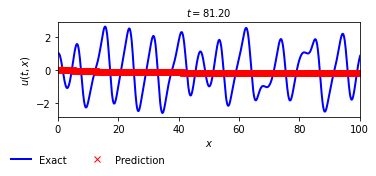

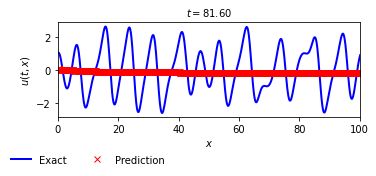

0.0 0.0 0.0
Loss: 1623558.197299332


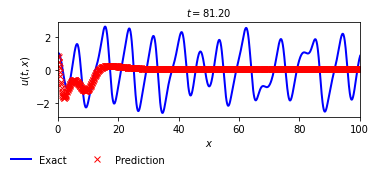

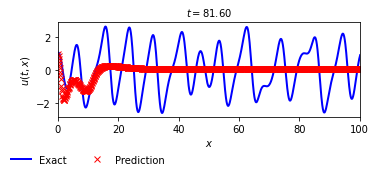

-0.024375291541218758 0.11969450116157532 0.0003244248509872705
Loss: 1531140.675189594


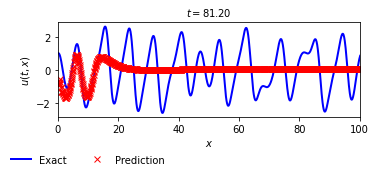

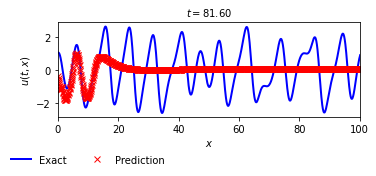

-0.027556555345654488 0.15545937418937683 0.00020551649504341185
Loss: 1496825.67309578


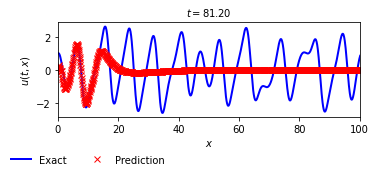

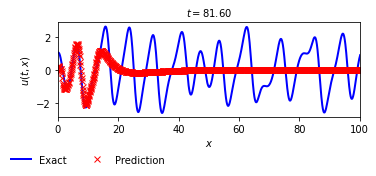

-0.011021485552191734 0.06575367599725723 7.630798791069537e-05
Loss: 1479099.6629983645


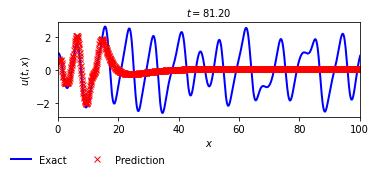

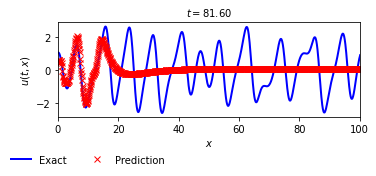

0.013952584937214851 -0.005594931077212095 8.43194175104145e-06
Loss: 1469904.7013427382


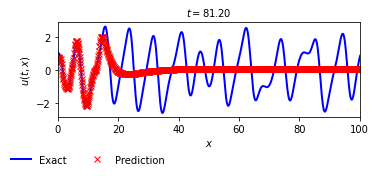

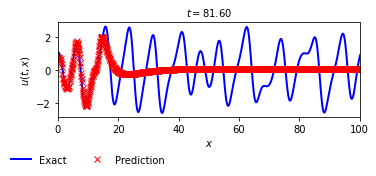

0.0359964519739151 -0.016007238999009132 -6.562735507031903e-06
Loss: 1463339.1810170352


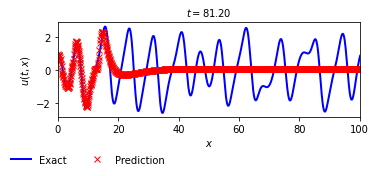

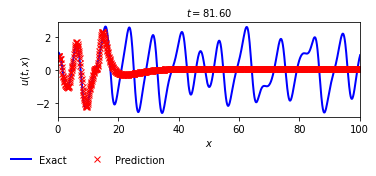

0.060428500175476074 -0.028353719040751457 -1.5615054508089088e-05
Loss: 1455422.3529624143


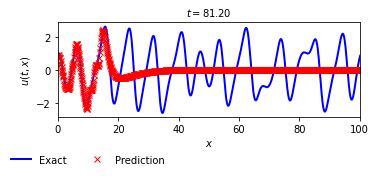

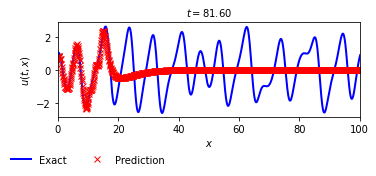

0.07937724143266678 -0.016626732423901558 -6.418971679522656e-06
Loss: 1447949.424137758


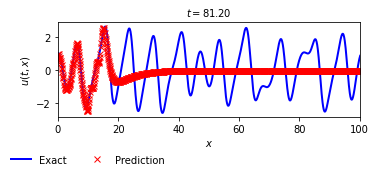

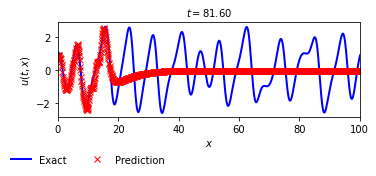

0.09692806750535965 -0.009002258069813251 -3.222311079298379e-06
Loss: 1434102.4331640112


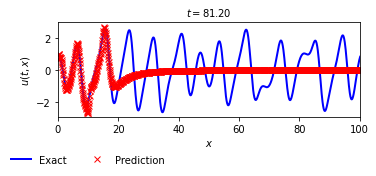

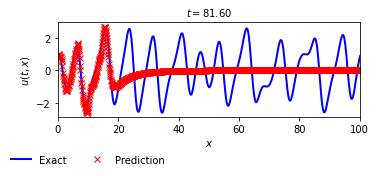

0.1188959926366806 0.0029116335790604353 -3.603626510084723e-06
Loss: 1419732.4133201558


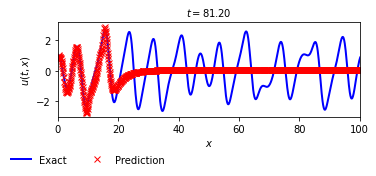

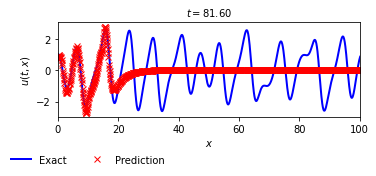

0.12306635826826096 0.006520901806652546 4.5178714458415925e-07
Loss: 1389078.9553920266


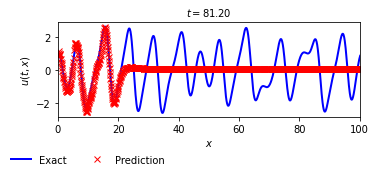

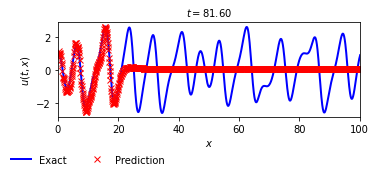

0.14742839336395264 0.004444659221917391 2.9365492082433775e-06
Loss: 1353865.1185910725


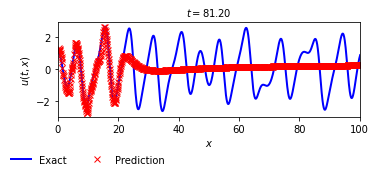

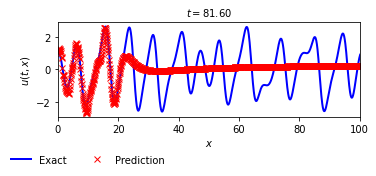

0.15774498879909515 -0.004890114534646273 1.2156102684457437e-06
Loss: 1338732.703155188


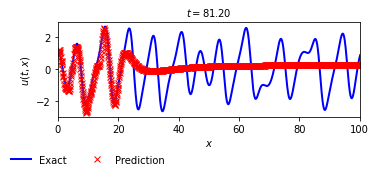

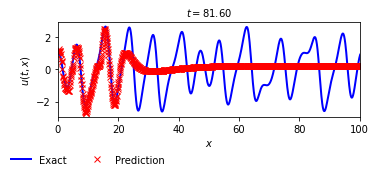

0.15869101881980896 0.0005317407776601613 1.5070664858285454e-06
Loss: 1324508.461495603


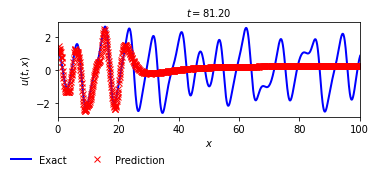

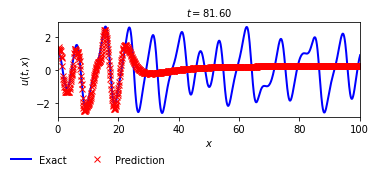

0.15945659577846527 0.009044205769896507 3.4147515179938637e-06
Loss: 1305714.2598988672


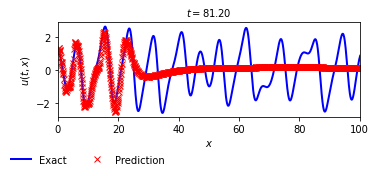

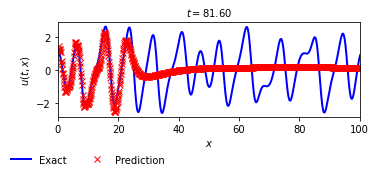

0.16304537653923035 0.006176435388624668 6.403369638974254e-07
Loss: 1293256.822941937


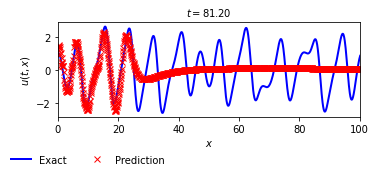

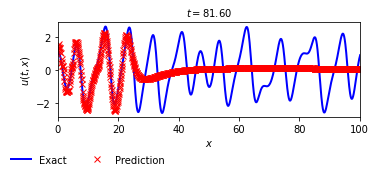

0.1696319282054901 -0.0024181881453841925 1.224683956024819e-06
Loss: 1277611.7908661678


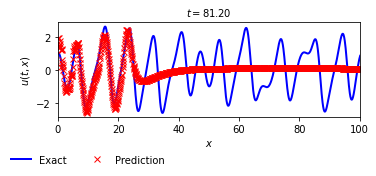

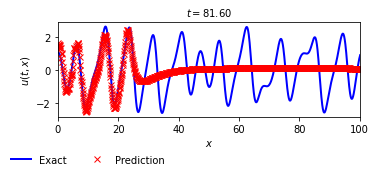

0.18143606185913086 -0.017750617116689682 -1.4096340237301774e-06
Loss: 1266576.8869478488


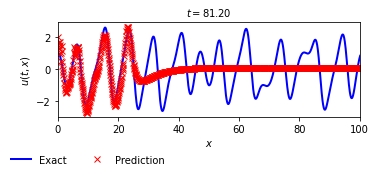

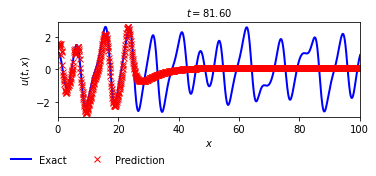

0.1881977617740631 -0.014348885044455528 -1.4700784731758176e-06
Loss: 1261874.6776236794


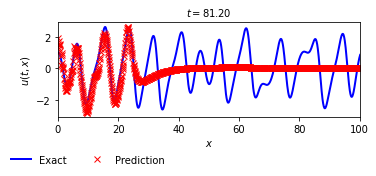

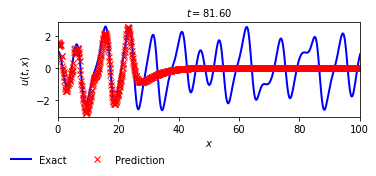

0.18882498145103455 -0.011112949810922146 -8.910189421840187e-07
Loss: 1250637.971895868


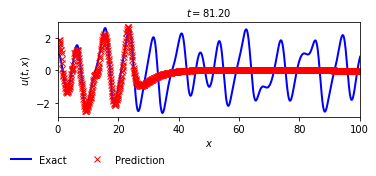

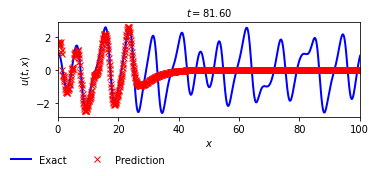

0.17824000120162964 0.010450419038534164 1.6918511391850188e-07
Loss: 1243748.3377884529


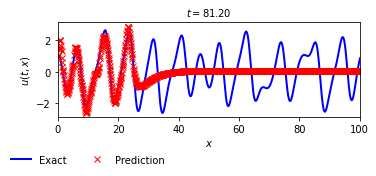

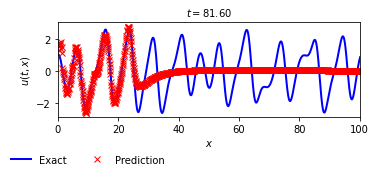

0.17051854729652405 0.008236437104642391 6.748895202690619e-07
Loss: 1241512.090175001


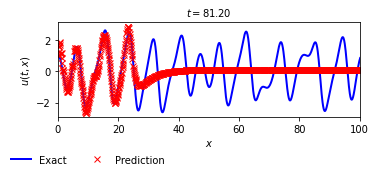

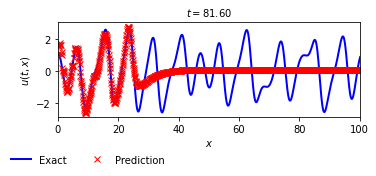

0.16507257521152496 0.0025564918760210276 2.1298680508152756e-07
Loss: 1234975.5128773432


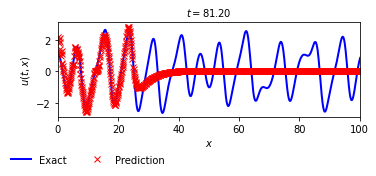

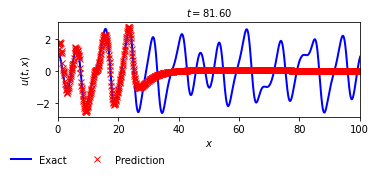

0.164275661110878 -0.009136490523815155 -3.7840877098460624e-08
Loss: 1234818.3081380962


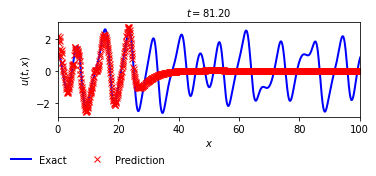

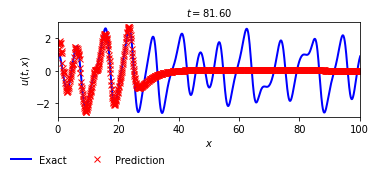

0.16296276450157166 -0.009201973676681519 -1.4576818330169772e-07
Loss: 1229712.672302513


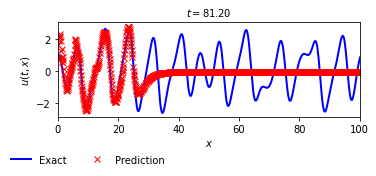

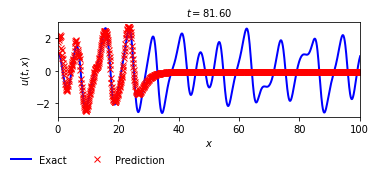

0.1477551907300949 -0.009281436912715435 -6.846794349257834e-07
Loss: 1224720.0574127273


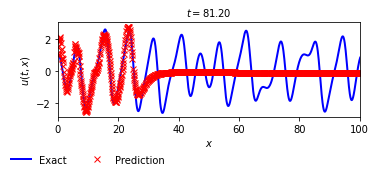

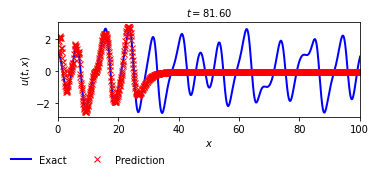

0.14630082249641418 -0.0012767657171934843 -8.530899009429049e-08


In [14]:
train.train()

In [15]:
print(net.lambda_1.item(), net.lambda_2.item(), net.lambda_3.item())

0.14729291200637817 -0.003758688224479556 -1.3919891728164657e-07


In [16]:
error_lambda_1 = np.abs(net.lambda_1.item() - 1.0)/1 * 100
error_lambda_2 = np.abs(net.lambda_2.item() - 1.0)/1 * 100
error_lambda_3 = np.abs(net.lambda_3.item() - 1.0)/1 * 100

print('Error lambda_1: %f%%' % (error_lambda_1))
print('Error lambda_2: %f%%' % (error_lambda_2))
print('Error lambda_3: %f%%' % (error_lambda_3))

Error lambda_1: 85.270709%
Error lambda_2: 100.375869%
Error lambda_3: 100.000014%


## PLOTTING

In [17]:
from matplotlib import cm

PLOTTIG FUNCTIONS

In [18]:
def plot_grid(u_plot, t_data, X_grid, T_grid, string_title, t_index_low=None, t_index_high=None):
    fig = plt.subplots(figsize=(8, 4))
    plt.contourf(T_grid, X_grid, u_plot, 1000, cmap=plt.get_cmap('Spectral'))
    plt.colorbar()
    plt.ylabel(r'$x$')
    plt.xlabel(r'$t$')
    plt.title(string_title, fontsize = 15) 

    try:
        fig[1].set_ylim(x_data.min(), x_data.max())
    
        
        line = np.linspace(x_data.min(), x_data.max(), 2)[:,None]
        fig[1].plot(t_data[t_index_low]*np.ones((2,1)) -0.1, line, 'k--', linewidth = 1)
        fig[1].plot(t_data[t_index_high]*np.ones((2,1)) +0.1, line, 'k--', linewidth = 1) 
    except Exception:
        pass    
    

    plt.show()
    plt.draw()
    #fig[0].savefig('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Images/spatio_temporal.png', bbox_inches='tight')
    plt.close()

def plot_time_step(x_data, x_input, t_data, u_data, u_pred, t_index, x_lb, x_ub, y_lb, y_ub):
    fig = plt.subplots(figsize=(3.2,2))
    fig[1].plot(x_data, u_data[t_index,:].T, 'b-', linewidth = 2, label = 'Exact') 
    fig[1].plot(x_input, u_pred[: ,-1].cpu().detach().numpy(), 'rx', linewidth = 2, label = 'Prediciton')      
    fig[1].set_xlabel('$x$')
    fig[1].set_ylabel('$u(t,x)$')    
    fig[1].set_title('$t = %.2f$' % (t_data[t_index]), fontsize = 15)
    fig[1].set_xlim([x_lb, x_ub])
    fig[1].set_ylim([y_lb, y_ub])
    fig[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=5, frameon=False)
    plt.show()
    #fig[1].figure.savefig('/content/drive/My Drive/ETH/Private/Bachelor Thesis/Images/spatio_pred_t%.2f' % t_data[t_index].item() + '.png', bbox_inches='tight')

PLOTTING TARGET DATA

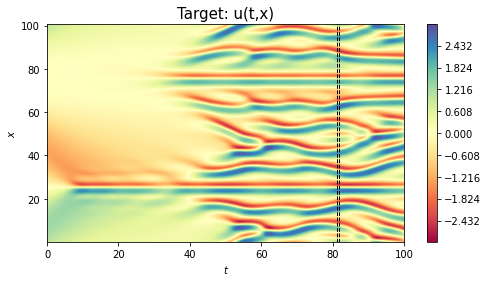

In [19]:
snapshot_index_low=idx_t0 
snapshot_index_high=idx_t1 

X, T = np.meshgrid(x_data, t_data)
u_target = u_data
plot_grid(u_target, t_data, X, T, 'Target: u(t,x)', snapshot_index_low, snapshot_index_high)

TARGET VS PREDICT AT SPECIFIC TIME STEPS


In [20]:
predict_0, predict_1 = net(train.train_input_0, train.train_input_1, train.dt, train.IRK_alpha, train.IRK_beta)

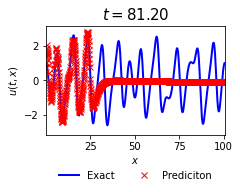

In [21]:
plot_time_step(x_data, train.train_input_0.cpu().detach(), t_data, u_target, predict_0, snapshot_index_low, x_data.min(), x_data.max(), u_target.min()*1.05, u_target.max()*1.05)

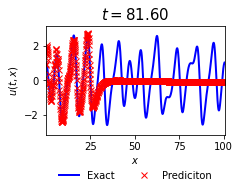

In [22]:
plot_time_step(x_data, train.train_input_1.cpu().detach(), t_data, u_target, predict_1, snapshot_index_high, x_data.min(), x_data.max(), u_target.min()*1.05, u_target.max()*1.05)

## SOLUTION

In [23]:

print('TARGET LAMBDA 3:',  1., 'TARGET LAMBDA 3:',  1., 'TARGET LAMBDA 3:',  1.)
print('\nPREDICTED LAMBDA 1:', net.lambda_1.item(), '\nPREDICTED LAMBDA 2:', net.lambda_2.item(), '\nPREDICTED LAMBDA 3:', net.lambda_3.item())

print('\nLAMBDA 1 ABSOLUTE ERROR:', np.abs((net.lambda_1.item() - 1)))
print('LAMBDA 2 ABSOLUTE ERROR:', np.abs((net.lambda_2.item() - 1)))
print('LAMBDA 3 ABSOLUTE ERROR:', np.abs((net.lambda_2.item() - 1))) #TARGET IS 1 IN ALL CASES SO RELATIVE ERRORS ARE EQUIVALENT

print('\nLAMBDA 1 RELATIVE ERROR:', np.abs((net.lambda_1.item() - 1)/1))
print('LAMBDA 2 RELATIVE ERROR:', np.abs((net.lambda_2.item() - 1) /1))
print('LAMBDA 3 RELATIVE ERROR:', np.abs((net.lambda_3.item() - 1) /1))

TARGET LAMBDA 3: 1.0 TARGET LAMBDA 3: 1.0 TARGET LAMBDA 3: 1.0

PREDICTED LAMBDA 1: 0.14729291200637817 
PREDICTED LAMBDA 2: -0.003758688224479556 
PREDICTED LAMBDA 3: -1.3919891728164657e-07

LAMBDA 1 ABSOLUTE ERROR: 0.8527070879936218
LAMBDA 2 ABSOLUTE ERROR: 1.0037586882244796
LAMBDA 3 ABSOLUTE ERROR: 1.0037586882244796

LAMBDA 1 RELATIVE ERROR: 0.8527070879936218
LAMBDA 2 RELATIVE ERROR: 1.0037586882244796
LAMBDA 3 RELATIVE ERROR: 1.0000001391989173


In [24]:
criterion = nn.MSELoss()
Error = criterion(predict_0[:, -1].view(-1, 1), train.train_target_0) + criterion( predict_1[:, -1].view(-1, 1), train.train_target_1)

print('L2 Norm Error:', Error.item())

Error_relative = Error / (torch.mean(torch.abs(u_0)) + torch.mean(torch.abs(u_1)))
print('Relative L2 Norm Error:', Error_relative.item())

L2 Norm Error: 2.6960634631116482
Relative L2 Norm Error: 1.1308619318120126
